# LISA

yet another PEFT

**Paper**: 
* LISA: Layerwise Importance Sampling for Memory-Efficient Large Language Model Fine-Tuning
* https://arxiv.org/abs/2403.17919

**Code**: https://github.com/OptimalScale/LMFlow

**LISA Approach**:
* Load all parameters, train a subset only, freeze the rest
* randomly select `lisa_activated_layers` number of layers and set `requires_grad=True`
* switch layers every `lisa_interval_steps` steps

**Integration with HF Trainer**:
* via Trainer Callback `DynamicLayerActivationCallback`
* init with params `lisa_activated_layers` and `lisa_interval_steps`
* `on_step_begin`: check current `step` vs `lisa_interval_steps`, call `switch_active_layers`

**Code below**:
* Load llama2-7b and prepare for ChatML
* Load Open Assistant data(sub)set, 4k examples
* `SFTTrainer` with constant LR of `2e-5` (`paged_adamw_8bit`), batch size 16, max seq. length 512. eval and save after each epoch
* Setup Trainer Callback with `lisa_activated_layers = 1` and `lisa_interval_steps = 20`
* Log with wandb
* 3 epochs in ~1.5hrs on a 3090 (VRAM usage ~21GB)

**Note**: seems to work, not thoroughly tested though

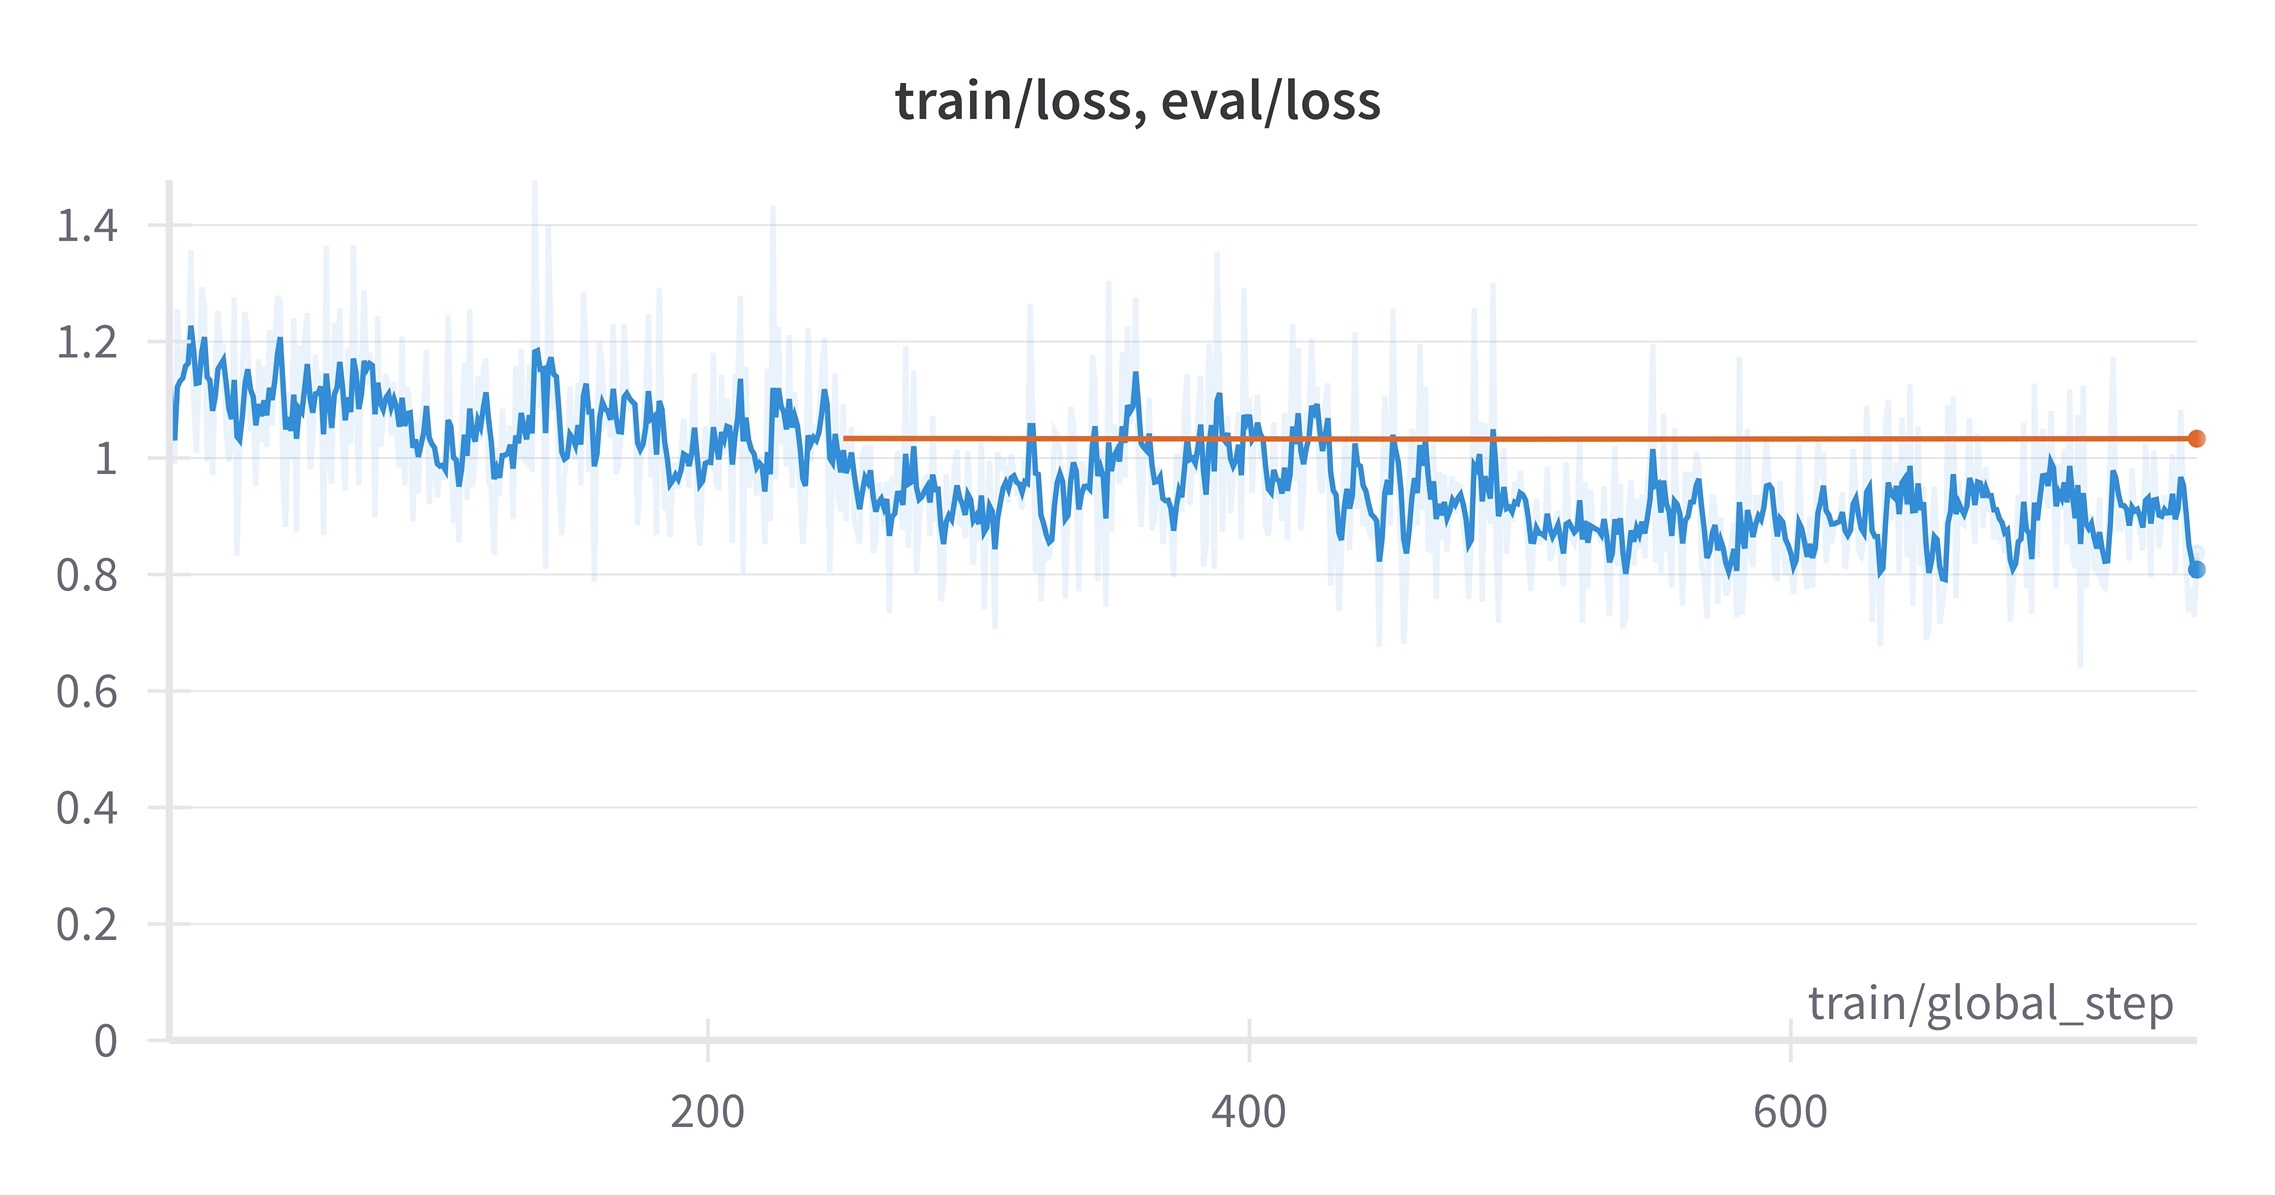

## Prerequisites

In [ ]:
!pip install -U bitsandbytes wandb flash_attn accelerate datasets trl transformers tokenizers 

## Load model, tokenizer, dataset

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, set_seed, get_constant_schedule
from trl import SFTTrainer, setup_chat_format, DataCollatorForCompletionOnlyLM
from datasets import load_dataset
import torch, uuid, wandb

set_seed(42)
run_id = f"LISA-{str(uuid.uuid4())}"

modelpath = "models/llama2-7b"

model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    torch_dtype = torch.bfloat16,
    attn_implementation = "flash_attention_2",  
    device_map = "auto",
    use_cache = False,
)
tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast = False)

model, tokenizer = setup_chat_format(model, tokenizer)
if tokenizer.pad_token in [None, tokenizer.eos_token]: 
    tokenizer.pad_token = tokenizer.unk_token

dataset = load_dataset("g-ronimo/oasst2_top4k_en")

## Setup `SFTTrainer`

In [ ]:
lr = 5e-5

training_arguments = TrainingArguments(
    output_dir = f"out_{run_id}",
    evaluation_strategy = "steps",
    label_names = ["labels"],
    per_device_train_batch_size = 16,
    save_steps = 250,
    eval_steps = 250,
    logging_steps = 1, 
    learning_rate = lr,
    num_train_epochs = 3,
    lr_scheduler_type = "constant",
    gradient_checkpointing = True,
    group_by_length = False,
    optim="paged_adamw_8bit",
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset['test'],
    data_collator = DataCollatorForCompletionOnlyLM(
        instruction_template = "<|im_start|>user", 
        response_template = "<|im_start|>assistant", 
        tokenizer = tokenizer, 
        mlm = False),
    max_seq_length = 512,
    dataset_kwargs = dict(add_special_tokens = False),
    args = training_arguments,
)

## Setup LISA

In [ ]:
lisa_activated_layers = 1
lisa_interval_steps = 20

In [ ]:
from transformers import TrainerCallback
import numpy as np

# source: https://github.com/OptimalScale/LMFlow/blob/main/src/lmflow/pipeline/finetuner.py
class DynamicLayerActivationCallback(TrainerCallback):
    def __init__(self, n_layers, interval_steps, model):
        super().__init__()
        self.n_layers = n_layers
        self.interval_steps = interval_steps
        self.model = model
        # Determine the way to access layers based on the model type
        if self.model.__class__.__name__ == 'LlamaForCausalLM':
            self.layers_attribute = 'model.model.layers'  # Layer access path for LlamaForCausalLM
        else:
            self.layers_attribute = 'model.transformer.h'  # General access path
        self.total_layers = len(eval('self.' + self.layers_attribute))  # Dynamically execute to get the number of layers

        # Freeze all layers upon initialization
        self.freeze_all_layers()
        self.active_layers_indices = []

    def freeze_all_layers(self):
        layers = eval('self.' + self.layers_attribute)  # Dynamically execute to get layers
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = False

    def on_step_begin(self, args, state, control, **kwargs):
        # Check if it's time to switch active layers, including at step 0
        if state.global_step % self.interval_steps == 0 or state.global_step == 1:
            self.switch_active_layers()

    def switch_active_layers(self):
        # First, disable gradients for all layers
        self.freeze_all_layers()

        # Randomly select n_layers to activate
        layers = eval('self.' + self.layers_attribute)  # Re-fetch layer references
        self.active_layers_indices = np.random.choice(range(self.total_layers), self.n_layers, replace=False)
        print(f"Activating layers at indices: {self.active_layers_indices} for the next steps.")

        # Enable gradients only for the selected layers
        for idx in self.active_layers_indices:
            for param in layers[idx].parameters():
                param.requires_grad = True

# Instantiate the callback
dynamic_layer_activation_callback = DynamicLayerActivationCallback(
    n_layers=lisa_activated_layers,                     # Number of layers to activate
    interval_steps = lisa_interval_steps,               # Step interval to update active layers
    model = model
)

trainer.add_callback(dynamic_layer_activation_callback)

## Train

In [ ]:
wandb.init(
    project = "LISA-7B", 
    name = run_id,
).log_code(include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

trainer.train()